
# Introduction to Regression.

    Author: Jerónimo Arenas García (jarenas@tsc.uc3m.es)
            Jesús Cid Sueiro (jcid@tsc.uc3m.es)

    Notebook version: 1.1 (Sep 12, 2017)

    Changes: v.1.0 - First version. Extracted from regression_intro_knn v.1.0.
             v.1.1 - Compatibility with python 2 and python 3

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import numpy as np
import scipy.io       # To read matlab files
import pandas as pd   # To read data tables from csv files

# For plots and graphical results
import matplotlib                 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   
import pylab

# For the student tests (only for python 2)
import sys
if sys.version_info.major==2:
    from test_helper import Test

# That's default image size for this interactive session
pylab.rcParams['figure.figsize'] = 9, 6  


## 1. The regression problem

The goal of regression methods is to predict the value of some *target* variable $S$ from the observation of one or more *input* variables $X_0, X_1, \ldots, X_{m-1}$ (that we will collect in a single vector $\bf X$).

Regression problems arise in situations where the value of the target variable is not easily accessible, but we can measure other dependent variables, from which we can try to predict $S$.  
<img src="figs/block_diagram.png" width=400>









The only information available to estimate the relation between the inputs and the target is a *dataset* $\mathcal D$ containing several observations of all variables.

$$\mathcal{D} = \{{\bf x}_{k}, s_{k}\}_{k=0}^{K-1}$$

The dataset $\mathcal{D}$ must be used to find a function $f$ that, for any observation vector ${\bf x}$, computes an output $\hat{s} = f({\bf x})$ that is a good predition of the true value of the target, $s$.

<img src="figs/predictor.png" width=300>

## 2. Examples of regression problems.

The <a href=http://scikit-learn.org/>scikit-learn</a> package contains several <a href=http://scikit-learn.org/stable/datasets/> datasets</a> related to regression problems. 

* **Boston dataset**: the target variable contains housing values in different suburbs of Boston. The goal is to predict these values based on several social, economic and demographic variables taken frome theses suburbs. (Dataset no longer available in sklearn).
* <a href=http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes /> Diabetes dataset</a>.
* **California housing**.


We can load these datasets as follows:

In [31]:
# Boston dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
S = raw_df.values[1::2, 2]

n_samples = X.shape[0]  # Number of observations
n_vars = X.shape[1]     # Number of variables (including input and target)

feature_names = [f'feature {i}' for i in range(n_vars)]

In [32]:
# Alternative dataset 1: Diabetes

# from sklearn import datasets
# Load the dataset. Select it by uncommenting the appropriate line
# D_all = datasets.load_diabetes()

# Extract data and data parameters.
# X = D_all.data         # Complete data matrix (including input and target variables)
# S = D_all.target      # Target variables
# feature_names = [f'feature {i}' for i in range(n_vars)]

In [33]:
# Alternative dataset 2: California Housing
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing()

# Extract data and data parameters.
# X = housing.data         # Complete data matrix (including input and target variables)
# S = housing.target      # Target variables
# info = housing.DESCR
# feature_names = housing.feature_names
# print(info)

In [34]:
n_samples = X.shape[0] # Number of observations
n_vars = X.shape[1]    # Number of variables (including input and target)

This dataset contains 

In [35]:
print(n_samples)

506


observations of the target variable and

In [36]:
print(n_vars)

13


input variables.

## 3. Scatter plots

### 3.1. 2D scatter plots

When the instances of the dataset are multidimensional, they cannot be visualized directly, but we can get a first rough idea about the regression task if we plot the target variable versus one of the input variables. These representations are known as <i>scatter plots</i>

Python methods `plot` and `scatter` from the `matplotlib` package can be used for these graphical representations. 

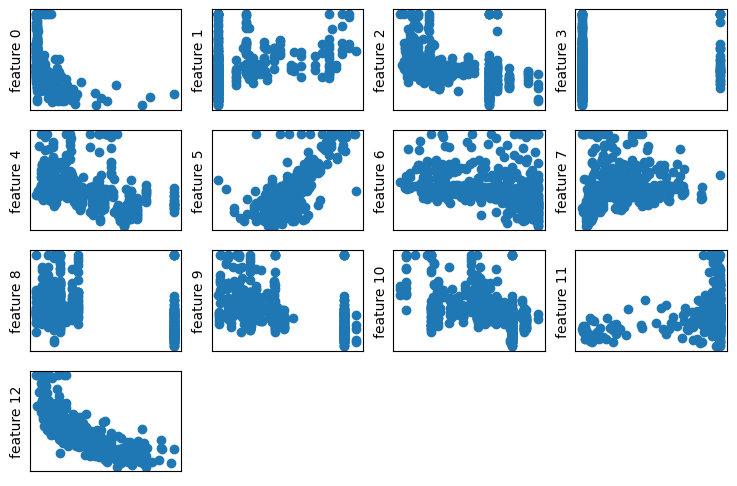

In [37]:
# Select a dataset
nrows = 4
ncols = 1 + (X.shape[1]-1) // nrows

# Some adjustment for the subplot.
pylab.subplots_adjust(hspace=0.2)

# Plot all variables
for idx in range(X.shape[1]):
    ax = plt.subplot(nrows,ncols,idx+1)
    ax.scatter(X[:,idx], S)    # <-- This is the key command
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.ylabel(f'{feature_names[idx]}')
    

### 3.2. 3D Plots

With the addition of a third coordinate, `plot` and `scatter` can be used for 3D plotting.

##### Exercise 1:

Select the `diabetes` dataset. Visualize the target versus components 2 and 4. (You can get more info about the <a href=http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter>scatter</a> command and an <a href=http://matplotlib.org/examples/mplot3d/scatter3d_demo.html>example of use</a> in the <a href=http://matplotlib.org/index.html> matplotlib</a> documentation)

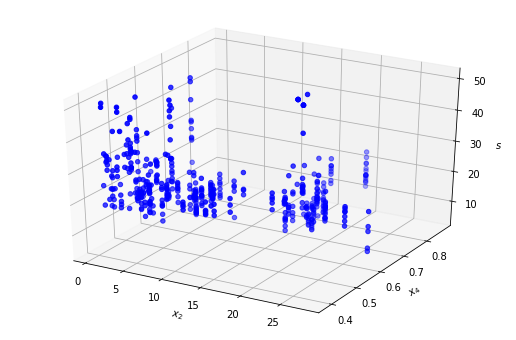

In [6]:
# <SOL>
x2 = X[:,2]
x4 = X[:,4]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x2, x4, S, zdir=u'z', s=20, c=u'b', depthshade=True)
ax.set_xlabel('$x_2$')
ax.set_ylabel('$x_4$')
ax.set_zlabel('$s$')
plt.show()
# </SOL>


## 4. Evaluating a regression task

In order to evaluate the performance of a given predictor, we need to quantify the quality of predictions. This is usually done by means of a loss function $l(s,\hat{s})$. Two common losses are

   * Square error: $l(s, \hat{s}) = (s - \hat{s})^2$
   * Absolute error: $l(s, \hat{s}) = |s - \hat{s}|$

Note that both the square and absolute errors are functions of the estimation error $e = s-{\hat s}$. However, this is not necessarily the case. As an example, imagine a situation in which we would like to introduce a penalty which increases with the magnitude of the estimated variable. For such case, the following cost would better fit our needs: $l(s,{\hat s}) = s^2 \left(s-{\hat s}\right)^2$.

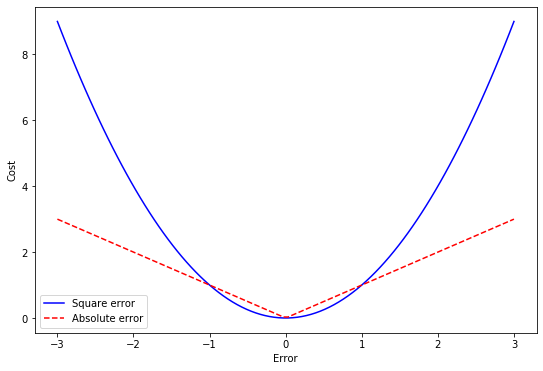

In [7]:
# In this section we will plot together the square and absolute errors
grid = np.linspace(-3,3,num=100)
plt.plot(grid, grid**2, 'b-', label='Square error')
plt.plot(grid, np.absolute(grid), 'r--', label='Absolute error')
plt.xlabel('Error')
plt.ylabel('Cost')
plt.legend(loc='best')
plt.show()

The overal prediction performance is computed as the average of the loss computed over a set of samples:

$${\bar R} = \frac{1}{K}\sum_{k=0}^{K-1} l\left(s_k, \hat{s}_k\right)$$

##### Exercise 2:

The dataset in file `'datasets/x01.csv'`, taken from <a href="http://people.sc.fsu.edu/~jburkardt/datasets/regression/x01.txt">here</a> records the average weight of the brain and body for a number of mammal species.
* Represent a scatter plot of the targe variable versus the one-dimensional input.
* Plot, over the same plot, the prediction function given by $S = 1.2 X$
* Compute the square error rate for the given dataset.

In [39]:
# Load dataset in arrays X and S
df = pd.read_csv('datasets/x01.csv', sep=',', header=None)
X = df.values[:,0]
S = df.values[:,1]

The average square error is 153781.94388919484


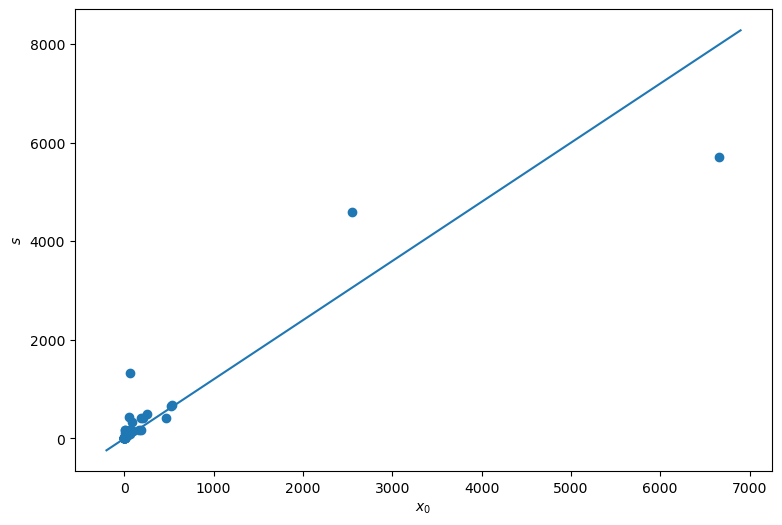

In [40]:
# <SOL>
fig = plt.figure()
plt.scatter(X, S)
plt.xlabel('$x_0$')
plt.ylabel('$s$')
xgrid = np.array([-200.0, 6900.0])
plt.plot(xgrid, 1.2*xgrid)

R = np.mean((S-1.2*X)**2)
print('The average square error is {0}'.format(R))
# </SOL>

In [9]:
if sys.version_info.major==2:
    Test.assertTrue(np.isclose(R, 153781.943889), 'Incorrect value for the average square error')
else:
    np.testing.assert_almost_equal(R, 153781.943889, decimal=4)
    print("Test passed")

Test passed


### 4.1. Training and test data

The major goal of the regression problem is that the predictor makes good predictions for arbitrary new inputs, not taken from the dataset used by the regression algorithm. 

Thus, in order to evaluate the prediction accuracy of some regression algorithm, we need some data, not used during the predictor design, to *test* the performance of the predictor under new data. To do so, the original dataset is usually divided in (at least) two disjoint sets:

* **Training set**, $\cal{D}_{\text{train}}$: Used by the regression algorithm to determine predictor $f$.
* **Test set**, $\cal{D}_{\text{test}}$: Used to evaluate the performance of the regression algorithm.

A good regression algorith uses $\cal{D}_{\text{train}}$ to obtain a predictor with small average loss based on $\cal{D}_{\text{test}}$
$$
{\bar R}_{\text{test}} = \frac{1}{K_{\text{test}}} 
\sum_{  ({\bf x},s) \in \mathcal{D}_{\text{test}}} l(s, f({\bf x}))
$$
where $K_{\text{test}}$ is the size of the test set.

## 5. Parametric and non-parametric regression models

Generally speaking, we can distinguish two approaches when designing a regression model:

   - Parametric approach: In this case, the estimation function is given <i>a priori</i> a parametric form, and the goal of the design is to find the most appropriate values of the parameters according to a certain goal
   
   For instance, we could assume a linear expression
   $${\hat s} = f({\bf x}) = {\bf w}^\top {\bf x}$$
   and adjust the parameter vector in order to minimize the average of the quadratic error over the training data. This is known as least-squares regression, and we will study it in a future session.
   
   - Non-parametric approach: In this case, the analytical shape of the regression model is not assumed <i>a priori</i>.
